<img src="./scr/pi1_mlops_modelo_header.png">

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
import joblib


Vamos a desarrollar el model de recomendaciones, usando la librería surprise. Emezamos siguiendo el proceso básico: instanciar, entrenar y predecir.

Posteriormen, haremos la evaluación del modelo y haremos unas métricas usando validación cruzada para encontrar los mejores hiperparámetros para nuestro modelo.

Finalmente concluiremos realizando una predicción

In [2]:
#instanciamos el reader()
reader = Reader()

In [4]:
#leemos el archivo de valoraciones preparado en el módulo anterior
data_valoraciones=pd.read_parquet('./datasets_parciales/valoraciones_para_modelo.parquet')
#data_valoraciones.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
#cargamos 400 mil registros del archivo 'valoraciones para modelo' preparado el 
dataSR_valoraciones = Dataset.load_from_df(data_valoraciones[['userId', 'movieId', 'rating']][:400000], reader)

In [6]:
#preparamos los conjuntos de entrenamiento y prueba, elegimos la recomendación general de 80-20
set_entreno, set_prueba = train_test_split(dataSR_valoraciones, test_size=.20)

In [7]:
#instanciamos el modelo
model = SVD()

In [8]:
#entrenamos el modelo (Yijaa!)
model.fit(set_entreno)

In [9]:
#predecimos sobre el conjunto de prueba
predictions = model.test(set_prueba)

In [10]:
#muestra una predicción cualquiera del conjunto de prueba
predictions[10]

Prediction(uid=251699, iid='ds379', r_ui=4.5, est=2.8202900377604214, details={'was_impossible': False})

In [11]:
#Vamos a evaluar el modelo antes de hacer predicciones al azar con validación cruzada
accuracy.rmse(predictions)

RMSE: 0.9951


0.9951457599767276

Hasta ahí parece bien el modelo, Vamos a optimizar los hiperparámetros a ver si podemos encontrar una configuración con mejores resultados

In [12]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256]

for factor in factores:
    print ('==================================================')
    print('Evaluando con ',factor,' factores')
    modelo_evaluado = SVD(n_factors=factor)
    resultado_cv = cross_validate(modelo_evaluado, dataSR_valoraciones, measures=['RMSE', 'MAE'], cv = 5, verbose=True)
    rmse_test_means.append(np.mean(resultado_cv['test_rmse']))

Evaluando con  1  factores
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9784  0.9806  0.9856  0.9828  0.9834  0.9821  0.0024  
MAE (testset)     0.7589  0.7618  0.7677  0.7636  0.7640  0.7632  0.0029  
Fit time          2.47    2.49    2.60    2.54    2.53    2.53    0.04    
Test time         1.32    0.96    0.96    1.20    1.23    1.13    0.15    
Evaluando con  2  factores
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9819  0.9825  0.9827  0.9798  0.9841  0.9822  0.0014  
MAE (testset)     0.7634  0.7627  0.7625  0.7617  0.7653  0.7631  0.0012  
Fit time          2.61    2.57    2.55    2.55    2.71    2.60    0.06    
Test time         0.96    0.93    1.21    1.25    0.97    1.06    0.14    
Evaluando con  4  factores
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

       

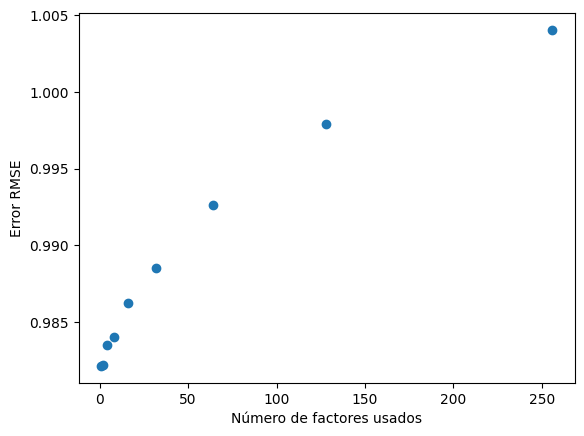

In [13]:
#vamos a graficar los resultados de la evaluación
plt.scatter(factores, rmse_test_means)
plt.xlabel('Número de factores usados')
plt.ylabel('Error RMSE')
plt.show()


Ahora nos detendremos a verificar el desempeñp del mejor modelo

In [14]:
from surprise.model_selection import GridSearchCV

parametros = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, parametros, measures=['RMSE', 'MAE'], cv=3, n_jobs = -1)
gs.fit(dataSR_valoraciones)

print('mejores puntajes : rmse ->',gs.best_score['rmse'],' mae ->',gs.best_score['mae'])
print('mejores parámetros : rmse ->',gs.best_params['rmse'],' mae ->',gs.best_params['mae'])

mejores puntajes : rmse -> 0.9726106420909386  mae -> 0.7574058326152722
mejores parámetros : rmse -> {'n_factors': 5, 'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.002}  mae -> {'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.002}


Ahora si, tenemos un modelo aceptablemente preciso. vamos a realizar una predicción para alguno de los usuario.


In [15]:
#entrenamos el modelo con los parámetros encontrado
modelo_mejor_evaluado = SVD(n_factors=5, n_epochs=5, lr_all=0.005, reg_all=0.002)

In [16]:
#entrenamos el mejor modelo encontrado (Yijaa! * 2)
modelo_mejor_evaluado.fit(set_entreno)
predictions = modelo_mejor_evaluado.test(set_prueba)

Vamos a hacer una predición para un usuario, ¿te gusta el usuario que esté en la posición 350,830 del dataset que ingresamos?

In [28]:
data_valoraciones

,userId,rating,timestamp,movieId
0,249182,3.5,2016-04-12,ds327
2,249182,3.0,2016-04-09,as8841
3,249182,4.5,2016-04-09,hs2318
4,249182,2.5,2016-04-09,as5743
5,249182,2.5,2016-04-09,ns7267
...,...,...,...,...
1499995,61768,3.5,2015-07-28,hs1021
1499996,61768,3.0,2015-07-28,hs885
1499997,61768,4.0,2015-06-30,as4321
1499998,61768,4.0,2015-07-28,hs2422


In [32]:
usuario_a_evaluar=data_valoraciones.iloc[350830]['userId']
print('usuario a evaluar',usuario_a_evaluar)

usuario a evaluar 253180


In [33]:
#veamos cuales películas ha visto y que mejor ha calificado, vamos por 3 para arriba
data_usuario = data_valoraciones[(data_valoraciones['rating']>=3.0) & (data_valoraciones['userId']==usuario_a_evaluar) ]
data_usuario

,userId,rating,timestamp,movieId
375691,253180,4.0,1996-06-05,as2367
375692,253180,3.0,1996-06-05,as106
375693,253180,3.0,1996-06-05,as3503
375694,253180,4.0,1996-06-05,ns2429
375695,253180,3.0,1996-06-05,ns3587
...,...,...,...,...
375765,253180,4.0,1996-06-05,ns3669
375766,253180,4.0,1996-06-05,hs445
375767,253180,3.0,1996-06-05,ns66
375768,253180,5.0,1996-06-05,ns351


Bueno, parece ser un usuario muy activo... veamos que podemos ofrecerle 

In [34]:
#cargamos el dataset de las películas y nos traemos el nombre
data_movies=pd.read_csv('./datasets_parciales/titles_total.csv')

In [35]:
data_movies.drop('Unnamed: 0',axis=1,inplace=True)
data_movies.head()

,type,title,director,cast,country,release_year,rating,listed_in,description,id,date_added_std,duration_int,duration_type,score
0,movie,duck the halls: a mickey mouse christmas special,"alonso ramirez ramos, dave wasson","chris diamantopoulos, tony anselmo, tress macn...",NaN,2016,tv-g,"animation, family",join mickey and the gang as they duck the halls!,ds1,2021-11-26,23,min,3.6
1,movie,ernest saves christmas,john cherry,"jim varney, noelle parker, douglas seale",NaN,1988,pg,comedy,santa claus passes his magic bag to a new st. ...,ds2,2021-11-26,91,min,3.5
2,movie,ice age: a mammoth christmas,karen disher,"raymond albert romano, john leguizamo, denis l...",united states,2011,tv-g,"animation, comedy, family",sid the sloth is on santa's naughty list.,ds3,2021-11-26,23,min,3.6
3,movie,the queen family singalong,hamish hamilton,"darren criss, adam lambert, derek hough, alexa...",NaN,2021,tv-pg,musical,"this is real life, not just fantasy!",ds4,2021-11-26,41,min,3.5
4,tv show,the beatles: get back,NaN,"john lennon, paul mccartney, george harrison, ...",NaN,2021,g,"docuseries, historical, music",a three-part documentary from peter jackson ca...,ds5,2021-11-25,1,season,3.5


In [36]:
#nos traemos el nombre de esas películas
data_usuario = pd.merge(left=data_usuario,right=data_movies[['id','title']], how='left', left_on=data_usuario.movieId, right_on='id')

In [37]:
data_usuario

,userId,rating,timestamp,movieId,id,title
0,253180,4.0,1996-06-05,as2367,as2367,george carlin: you are all diseased
1,253180,3.0,1996-06-05,as106,as106,why we fight
2,253180,3.0,1996-06-05,as3503,as3503,2019 avp austin open - day 2
3,253180,4.0,1996-06-05,ns2429,ns2429,overnight republic
4,253180,3.0,1996-06-05,ns3587,ns3587,the little switzerland
...,...,...,...,...,...,...
67,253180,4.0,1996-06-05,ns3669,ns3669,4l
68,253180,4.0,1996-06-05,hs445,hs445,exit plan
69,253180,3.0,1996-06-05,ns66,ns66,numberblocks
70,253180,5.0,1996-06-05,ns351,ns351,space cowboys


sacamos las películas que desde el modulo "EDA" decidimos no considerar, para dejar el universo de 
películas evaluadas y quitar, además las películas que ya vió el usuario en cuestión

In [39]:
#películas no consideradas
data_peliculas_fuera = pd.read_csv('./datasets_parciales/moviesId_noconsideradas.csv')
data_peliculas_fuera.drop('Unnamed: 0', axis=1)

,id
0,ns8168
1,as5312
2,as7644
3,as7249
4,as2553
...,...
1506,as8336
1507,ns8250
1508,ds978
1509,as7617


In [43]:
data_movies.shape

(22998, 14)

In [45]:
#quitarlas de data_movies, nos deben quedar 22,998 - 1,511 =  21,487
data_movies_seleccionado = data_movies[~data_movies['id'].isin(data_peliculas_fuera['id'])]
data_movies_seleccionado.shape

se supone que borra


(21487, 14)

In [46]:
data_recomendaciones_posibles = data_movies_seleccionado[['id','title','score']]

In [47]:
data_recomendaciones_posibles.head()

,id,title,score
0,ds1,duck the halls: a mickey mouse christmas special,3.6
1,ds2,ernest saves christmas,3.5
2,ds3,ice age: a mammoth christmas,3.6
3,ds4,the queen family singalong,3.5
4,ds5,the beatles: get back,3.5


Teniendo el universo de películas, se hace la recomendación

In [48]:
#
data_recomendaciones_posibles['ScoreEstimado'] = data_recomendaciones_posibles['id'].apply(lambda x: modelo_mejor_evaluado.predict(usuario_a_evaluar, x).est)

/tmp/ipykernel_12064/4042930965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_recomendaciones_posibles['ScoreEstimado'] = data_recomendaciones_posibles['id'].apply(lambda x: modelo_mejor_evaluado.predict(usuario_a_evaluar, x).est)


¡Por fin! mostramos las 10 películas que le podemos recomendar al usuario elegido

In [49]:
data_recomendaciones_posibles.sort_values('ScoreEstimado', ascending = False, inplace=True)
data_recomendaciones_posibles.head()

/tmp/ipykernel_12064/3889983438.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_recomendaciones_posibles.sort_values('ScoreEstimado', ascending = False, inplace=True)


,id,title,score,ScoreEstimado
14471,ns281,bake squad,3.6,3.811629
19666,ns5476,hasan minhaj: homecoming king,3.6,3.796603
2090,as641,the gospel live,3.6,3.794496
5684,as4235,seagulls,3.5,3.775770
14534,ns344,my girl,3.5,3.774064


Ahora vamos a exportar nuestro modelo ya entrenado, evaluado y optimizado, para crear una aplicación que muestre las predicciones en una interfaz amigable.

Casi terminamos!

In [52]:
#guardo el modelo!
joblib.dump(modelo_mejor_evaluado, './datasets_parciales/modelo_recomendaciones_entrenado.pkl')

['./datasets_parciales/modelo_recomendaciones_entrenado.pkl']